# Image Generation Pipeline Demonstration

This notebook provides a comprehensive step-by-step demonstration of the image generation pipeline capabilities. We'll showcase various features including quality assessment, segmentation, mask refinement, and background replacement with different techniques.

## 1. Setup and Initialization

First, we'll import the necessary components and initialize the pipeline.

Added /home/pablo/image_generation_module to sys.path


/home/pablo/image_generation_module/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA Available: True
GPU: NVIDIA GeForce GTX 1060 with Max-Q Design
2025-04-28 00:30:48,692 - INFO - root - Initializing pipeline components...
2025-04-28 00:30:49,412 - INFO - root - Segmenter initialized with rembg model: isnet-general-use
2025-04-28 00:30:49,413 - INFO - root - Segmenter initialized with model: isnet-general-use
2025-04-28 00:30:49,413 - INFO - root - ImageAssessor initialized.
2025-04-28 00:30:49,413 - INFO - root - Diffusion is enabled. Initializing Diffusion Generator...
2025-04-28 00:30:49,414 - INFO - root - Initializing Diffusion Generator with effective config: {'sd_model_id': 'runwayml/stable-diffusion-v1-5', 'custom_controlnet_id': 'lllyasviel/sd-controlnet-seg', 'controlnet_type': 'seg', 'device': 'cuda', 'scheduler_type': 'DDIM', 'enable_cpu_offload': False}
2025-04-28 00:30:49,415 - INFO - root - Initializing DiffusionGenerator on device: cuda with dtype: torch.float16
2025-04-28 00:30:49,416 - INFO - root - Loading Stable Diffusion model: runwayml/stabl

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


2025-04-28 00:30:53,234 - INFO - root - Diffusion pipeline initialized successfully.
2025-04-28 00:30:53,235 - INFO - root - Diffusion Generator initialized successfully.
2025-04-28 00:30:53,236 - INFO - root - Pipeline initialized.
Pipeline initialized successfully.
Segmentation model: isnet-general-use
Diffusion enabled: True
Loaded demo image: 961939-MLC77038553924_062024.jpg
Image dimensions: 1920x1383


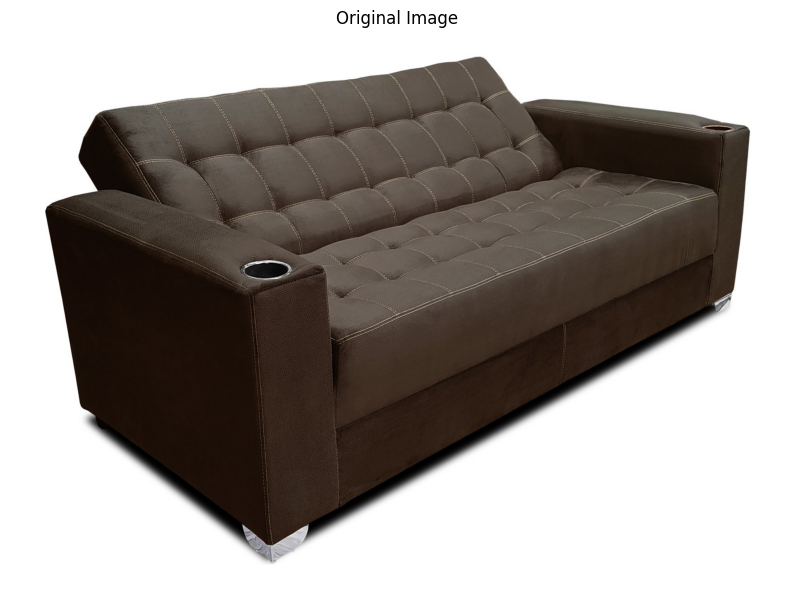

In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import time
import torch

# Add the parent directory to the path to allow importing from src
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"Added {project_root} to sys.path")

# Import pipeline components
from src.pipeline.main_pipeline import GenerationPipeline
from src.image.quality import ImageAssessor
from src.image.segmentation import Segmenter
from src.image.filtering import refine_morphological
from src.utils.data_io import load_image, save_image
from src.background.generators import generate_solid_background, generate_gradient_background
from src.background.utils import combine_foreground_background
from src.models.diffusion import DiffusionGenerator
from src.config import DEFAULT_CONFIG

# Set up display utilities
def display_images(images, titles=None, figsize=(15, 10), rows=1):
    """Display multiple images in a row with titles."""
    cols = len(images) // rows if len(images) % rows == 0 else len(images) // rows + 1
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        if isinstance(image, np.ndarray):
            if image.ndim == 2 or (image.ndim == 3 and image.shape[2] == 1):
                # Grayscale image
                plt.imshow(image, cmap='gray')
            else:
                # Assume RGB order for numpy arrays
                plt.imshow(image)
        else:
            # Assume PIL image
            plt.imshow(np.array(image))
        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Path to the demo image
IMAGE_PATH = project_root / "data" / "images" / "961939-MLC77038553924_062024.jpg"

# Create results directory for intermediate outputs
RESULTS_DIR = project_root / "results" / "demo_outputs"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")
if cuda_available:
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    
# Initialize the pipeline
try:
    # Enable diffusion for the demonstration
    pipeline = GenerationPipeline(diffusion_enabled=True)
    print("Pipeline initialized successfully.")
    print(f"Segmentation model: {pipeline.segmenter.model_name}")
    print(f"Diffusion enabled: {pipeline.diffusion_generator is not None}")
except Exception as e:
    print(f"Error initializing pipeline: {e}")
    # Fallback to non-diffusion pipeline if needed
    print("Falling back to non-diffusion pipeline...")
    pipeline = GenerationPipeline(diffusion_enabled=False)

# Load the demo image
try:
    demo_image_pil = load_image(IMAGE_PATH)
    demo_image_np = np.array(demo_image_pil)
    print(f"Loaded demo image: {IMAGE_PATH.name}")
    print(f"Image dimensions: {demo_image_pil.size[0]}x{demo_image_pil.size[1]}")
    plt.figure(figsize=(10, 10))
    plt.imshow(demo_image_pil)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
except Exception as e:
    print(f"Error loading demo image: {e}")

## 2. Image Quality Assessment

Let's evaluate the quality of the input image to determine if it's suitable for processing.

In [2]:
# Assess image quality
assessor = pipeline.assessor
quality_results = assessor.assess_quality(demo_image_pil)

print("Quality Assessment Results:")
print(f"Resolution: {quality_results['resolution']['width']}x{quality_results['resolution']['height']}")
print(f"Resolution check: {'Passed' if quality_results['resolution']['passed'] else 'Failed'}")
print(f"Blur value: {quality_results['blur']['value']}")
print(f"Blur check: {'Passed' if quality_results['blur']['passed'] else 'Failed'}")
print(f"Contrast value: {quality_results['contrast']['value']}")
print(f"Contrast check: {'Passed' if quality_results['contrast']['passed'] else 'Failed'}")
print(f"\nOverall quality: {quality_results['overall_quality']}")
print(f"Is processable: {quality_results['is_processable']}")
print(f"Message: {quality_results['message']}")

# Get processing strategy recommendation
strategy = assessor.recommend_processing_strategy(quality_results)
print("\nRecommended Processing Strategy:")
print(f"Suggested segmentation model: {strategy['segmentation_model']}")
print(f"Mask refinement operations: {strategy['mask_refinement_ops']}")
print(f"Suggested background type: {strategy['suggested_background_type']}")

Quality Assessment Results:
Resolution: 1920x1383
Resolution check: Passed
Blur value: 127.7
Blur check: Passed
Contrast value: 101.98
Contrast check: Passed

Overall quality: excellent
Is processable: True
Message: Image quality is excellent.

Recommended Processing Strategy:
Suggested segmentation model: u2net
Mask refinement operations: [{'type': 'close', 'kernel_size': 5, 'iterations': 1}, {'type': 'dilate', 'kernel_size': 3, 'iterations': 1}]
Suggested background type: gradient


## 3. Segmentation Process

Now we'll segment the image to isolate the foreground object from the background.

Using segmentation model: isnet-general-use
2025-04-28 00:30:55,281 - INFO - root - Saved raw mask to /home/pablo/image_generation_module/results/demo_outputs/demo_mask_raw.png
Segmentation completed in 1.67 seconds
Mask Quality Metrics:
Coverage: 52.57%
Complexity: 0.0037
Contours: 1
Is valid: True


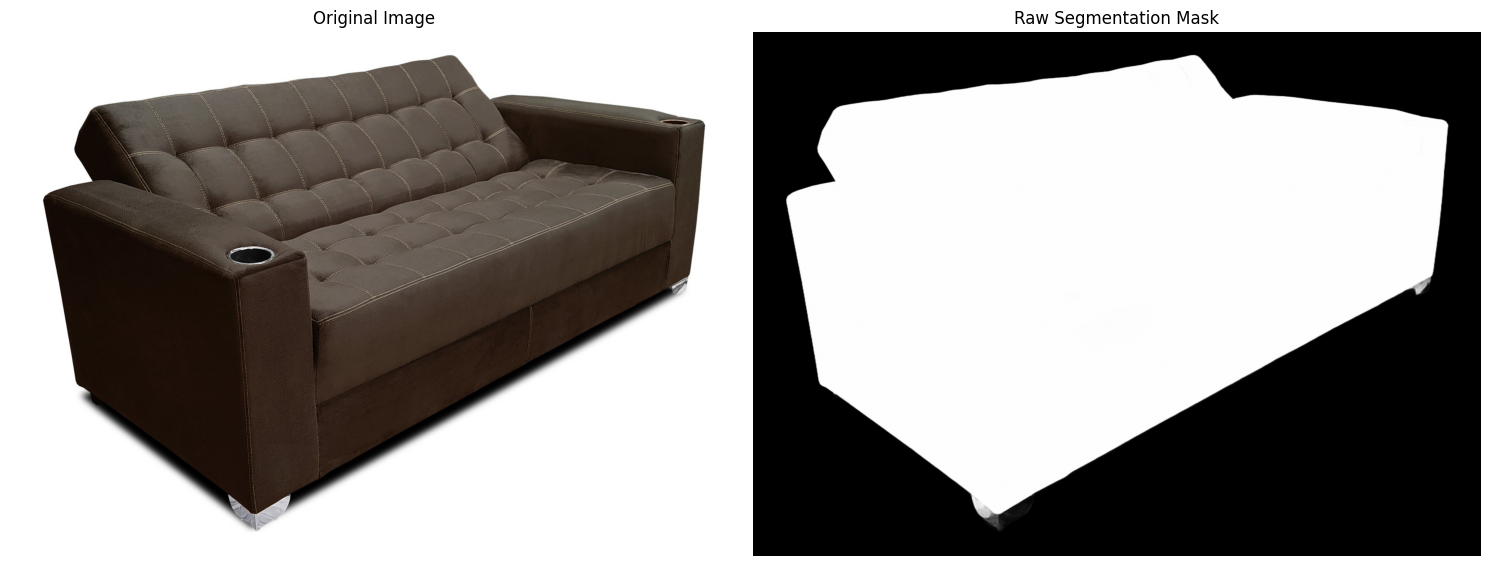

In [3]:
# Get the segmenter instance from the pipeline
segmenter = pipeline.segmenter
print(f"Using segmentation model: {segmenter.model_name}")

# Segment the image
start_time = time.time()
raw_mask = segmenter.segment(demo_image_np, 
                             save_intermediate=True, 
                             intermediate_dir=RESULTS_DIR, 
                             output_basename="demo")
segmentation_time = time.time() - start_time
print(f"Segmentation completed in {segmentation_time:.2f} seconds")

# Evaluate mask quality
mask_quality = segmenter.evaluate_mask_quality(raw_mask)
print("Mask Quality Metrics:")
print(f"Coverage: {mask_quality['coverage']}%")
print(f"Complexity: {mask_quality['complexity']}")
print(f"Contours: {mask_quality['contours']}")
print(f"Is valid: {mask_quality['is_valid']}")

# Visualize the raw mask
display_images([demo_image_pil, raw_mask], 
               titles=["Original Image", "Raw Segmentation Mask"])

## 4. Mask Refinement and Filtering

Let's refine the raw mask and apply various filters to improve the quality.


--- MASK VALIDATION FILTERS ---
These filters check if the segmentation mask is suitable for processing.

Contrast Filter:
Passed: True
Reason: Contrast sufficient
This filter checks if there's sufficient contrast between the foreground object and its immediate background.

Contour Filter:
Passed: True
Reason: Contour properties acceptable
This filter checks geometric properties like complexity, fragmentation, and size.

Clutter Filter: (Note: Requires ultralytics package with YOLO)
This filter uses object detection to identify primary objects and check for overlaps.
Passed: True
Reason: Clutter check passed

--- MASK REFINEMENT ---
Applying morphological operations to refine the mask.


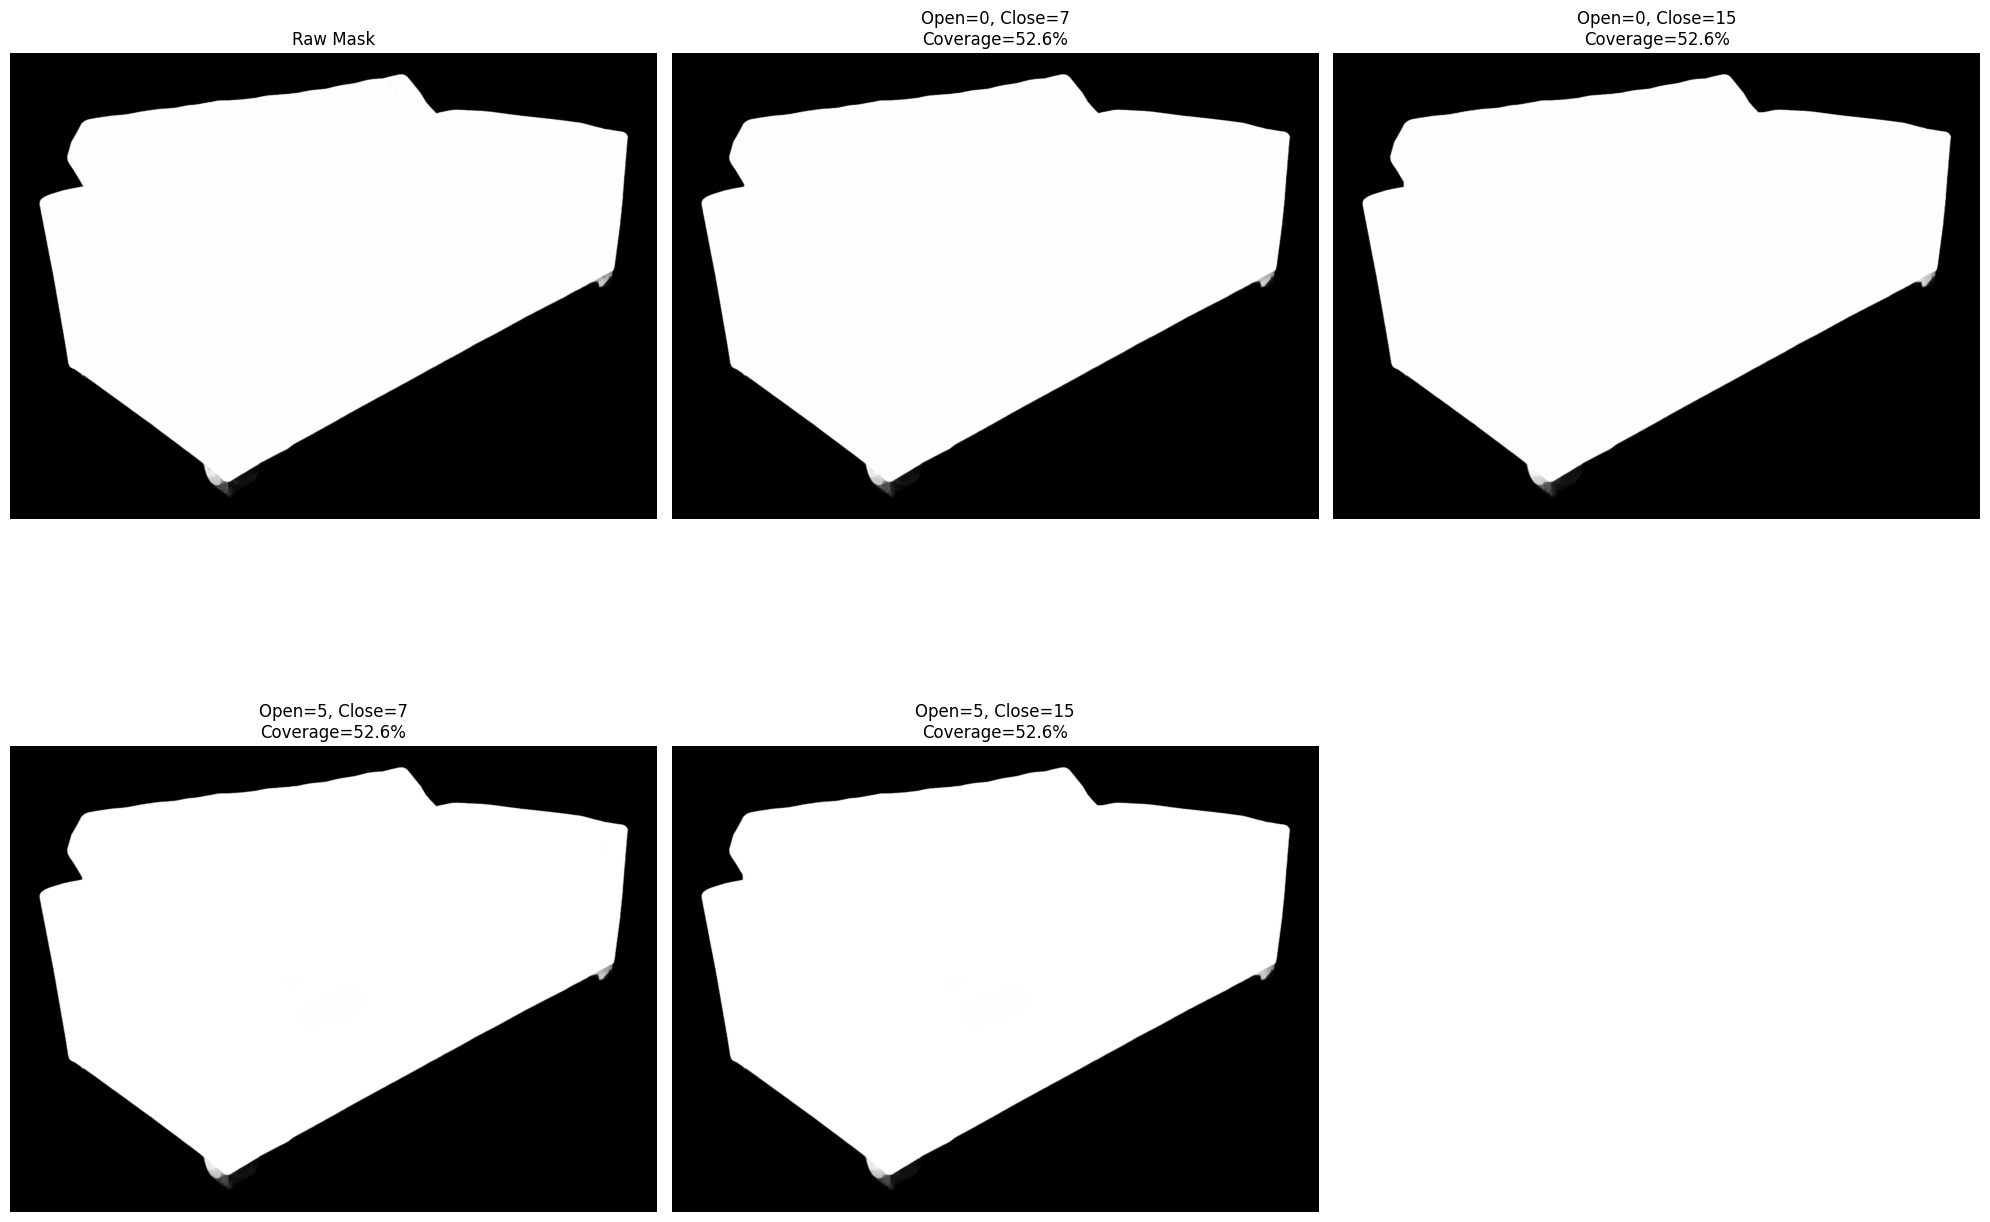


--- EDGE FEATHERING ---
Applying edge feathering for smoother compositing.


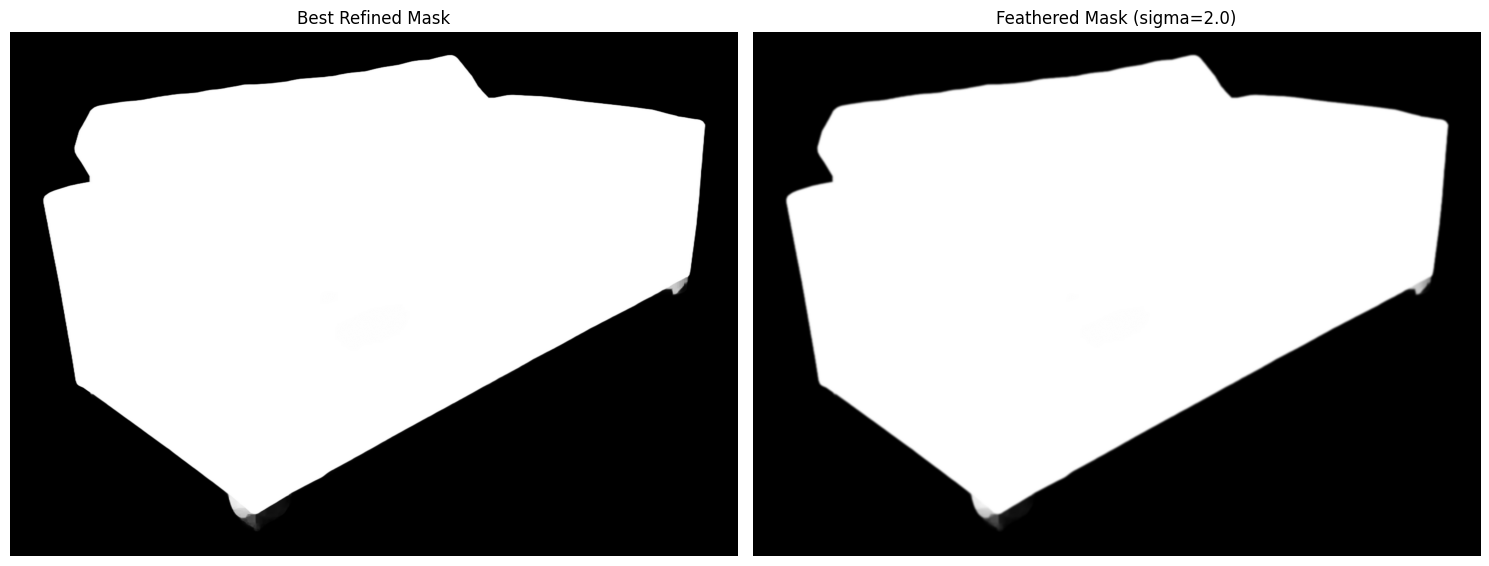

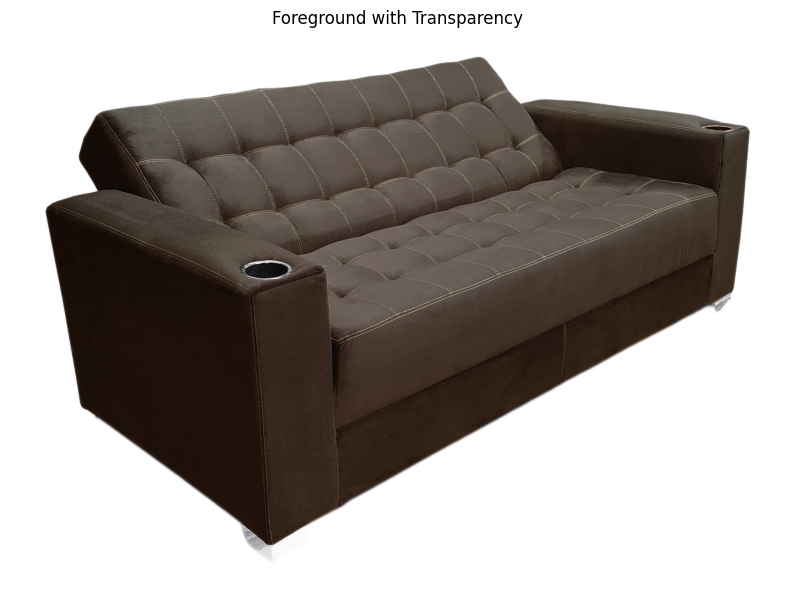

In [4]:
# Import filtering functions
from src.image.filtering import filter_by_contrast, filter_by_contour, filter_by_clutter, refine_morphological

# 4.1 First, demonstrate the different filters available in the pipeline
print("\n--- MASK VALIDATION FILTERS ---")
print("These filters check if the segmentation mask is suitable for processing.")

# Make a copy of the default config and enable filters
filter_config = DEFAULT_CONFIG.copy()
filter_config['contrast_filter_threshold'] = 10.0
filter_config['contrast_band_width'] = 3
filter_config['contour_max_points'] = 2500
filter_config['contour_max_count'] = 5
filter_config['contour_min_solidity'] = 0.7
filter_config['contour_min_area_ratio'] = 0.01
filter_config['contour_max_area_ratio'] = 0.95

# Apply the contrast filter
contrast_result, contrast_reason = filter_by_contrast(demo_image_np, raw_mask, filter_config)
print(f"\nContrast Filter:")
print(f"Passed: {contrast_result}")
print(f"Reason: {contrast_reason}")
print(f"This filter checks if there's sufficient contrast between the foreground object and its immediate background.")

# Apply the contour filter
contour_result, contour_reason = filter_by_contour(demo_image_np, raw_mask, filter_config)
print(f"\nContour Filter:")
print(f"Passed: {contour_result}")
print(f"Reason: {contour_reason}")
print(f"This filter checks geometric properties like complexity, fragmentation, and size.")

# Note about clutter filter
print(f"\nClutter Filter: (Note: Requires ultralytics package with YOLO)")
print("This filter uses object detection to identify primary objects and check for overlaps.")
try:
    clutter_result, clutter_reason = filter_by_clutter(demo_image_np, raw_mask, filter_config)
    print(f"Passed: {clutter_result}")
    print(f"Reason: {clutter_reason}")
except Exception as e:
    print(f"Clutter filter not available: {e}")
    print("If you need this filter, install ultralytics with: pip install ultralytics")


# 4.2 Now continue with the mask refinement using morphological operations
print("\n--- MASK REFINEMENT ---")
print("Applying morphological operations to refine the mask.")

# Make a copy of the default config
refinement_config = DEFAULT_CONFIG.copy()

# Define parameters for different refinement operations
opening_sizes = [0, 5]  # 0 means disabled, 5 is kernel size
closing_sizes = [7, 15]  # Kernel sizes for closing operation

# Store masks for visualization
refined_masks = [raw_mask]  # Start with the raw mask
mask_titles = ["Raw Mask"]

# Apply different morphological operations
for opening_size in opening_sizes:
    for closing_size in closing_sizes:
        # Update config
        refinement_config["mask_opening_kernel_size"] = opening_size
        refinement_config["mask_opening_iterations"] = 1
        refinement_config["mask_closing_kernel_size"] = closing_size
        refinement_config["mask_closing_iterations"] = 1
        
        # Refine mask
        refined_mask = refine_morphological(raw_mask.copy(), refinement_config)
        
        # Evaluate refined mask quality
        refined_quality = segmenter.evaluate_mask_quality(refined_mask)
        
        # Add to display list
        refined_masks.append(refined_mask)
        mask_titles.append(f"Open={opening_size}, Close={closing_size}\nCoverage={refined_quality['coverage']:.1f}%")
        
        # Save the refined mask
        refined_path = RESULTS_DIR / f"demo_refined_o{opening_size}_c{closing_size}.png"
        save_image(Image.fromarray(refined_mask), refined_path)
        
# Display the masks
display_images(refined_masks, mask_titles, figsize=(20, 15), rows=2)

# Choose the best refined mask based on the results
best_config = refinement_config.copy()
best_config["mask_opening_kernel_size"] = 5
best_config["mask_closing_kernel_size"] = 15
best_mask = refine_morphological(raw_mask.copy(), best_config)

# Apply edge feathering (for smoother edges)
print("\n--- EDGE FEATHERING ---")
print("Applying edge feathering for smoother compositing.")
feather_amount = 2.0  # Sigma for gaussian blur
if feather_amount > 0:
    mask_float = best_mask.astype(np.float32) / 255.0
    k_size = int(6 * feather_amount + 1)
    if k_size % 2 == 0: k_size += 1
    feathered_mask_float = cv2.GaussianBlur(mask_float, (k_size, k_size), feather_amount)
    feathered_mask = (feathered_mask_float * 255).clip(0, 255).astype(np.uint8)
    
    # Display feathering effect
    display_images([best_mask, feathered_mask], 
                 titles=["Best Refined Mask", f"Feathered Mask (sigma={feather_amount})"])
else:
    feathered_mask = best_mask
    print("Feathering skipped (amount = 0)")

# Save the feathered mask
save_image(Image.fromarray(feathered_mask), RESULTS_DIR / "demo_mask_feathered.png")

# Create RGBA foreground (using final mask)
foreground_rgba_np = cv2.cvtColor(demo_image_np, cv2.COLOR_RGB2RGBA)
foreground_rgba_np[:, :, 3] = feathered_mask

# Visualize the foreground with transparency
plt.figure(figsize=(10, 10))
plt.imshow(foreground_rgba_np)
plt.title("Foreground with Transparency")
plt.axis('off')
plt.show()

## 5. Background Replacement - Solid Color

Now let's replace the background with solid colors.

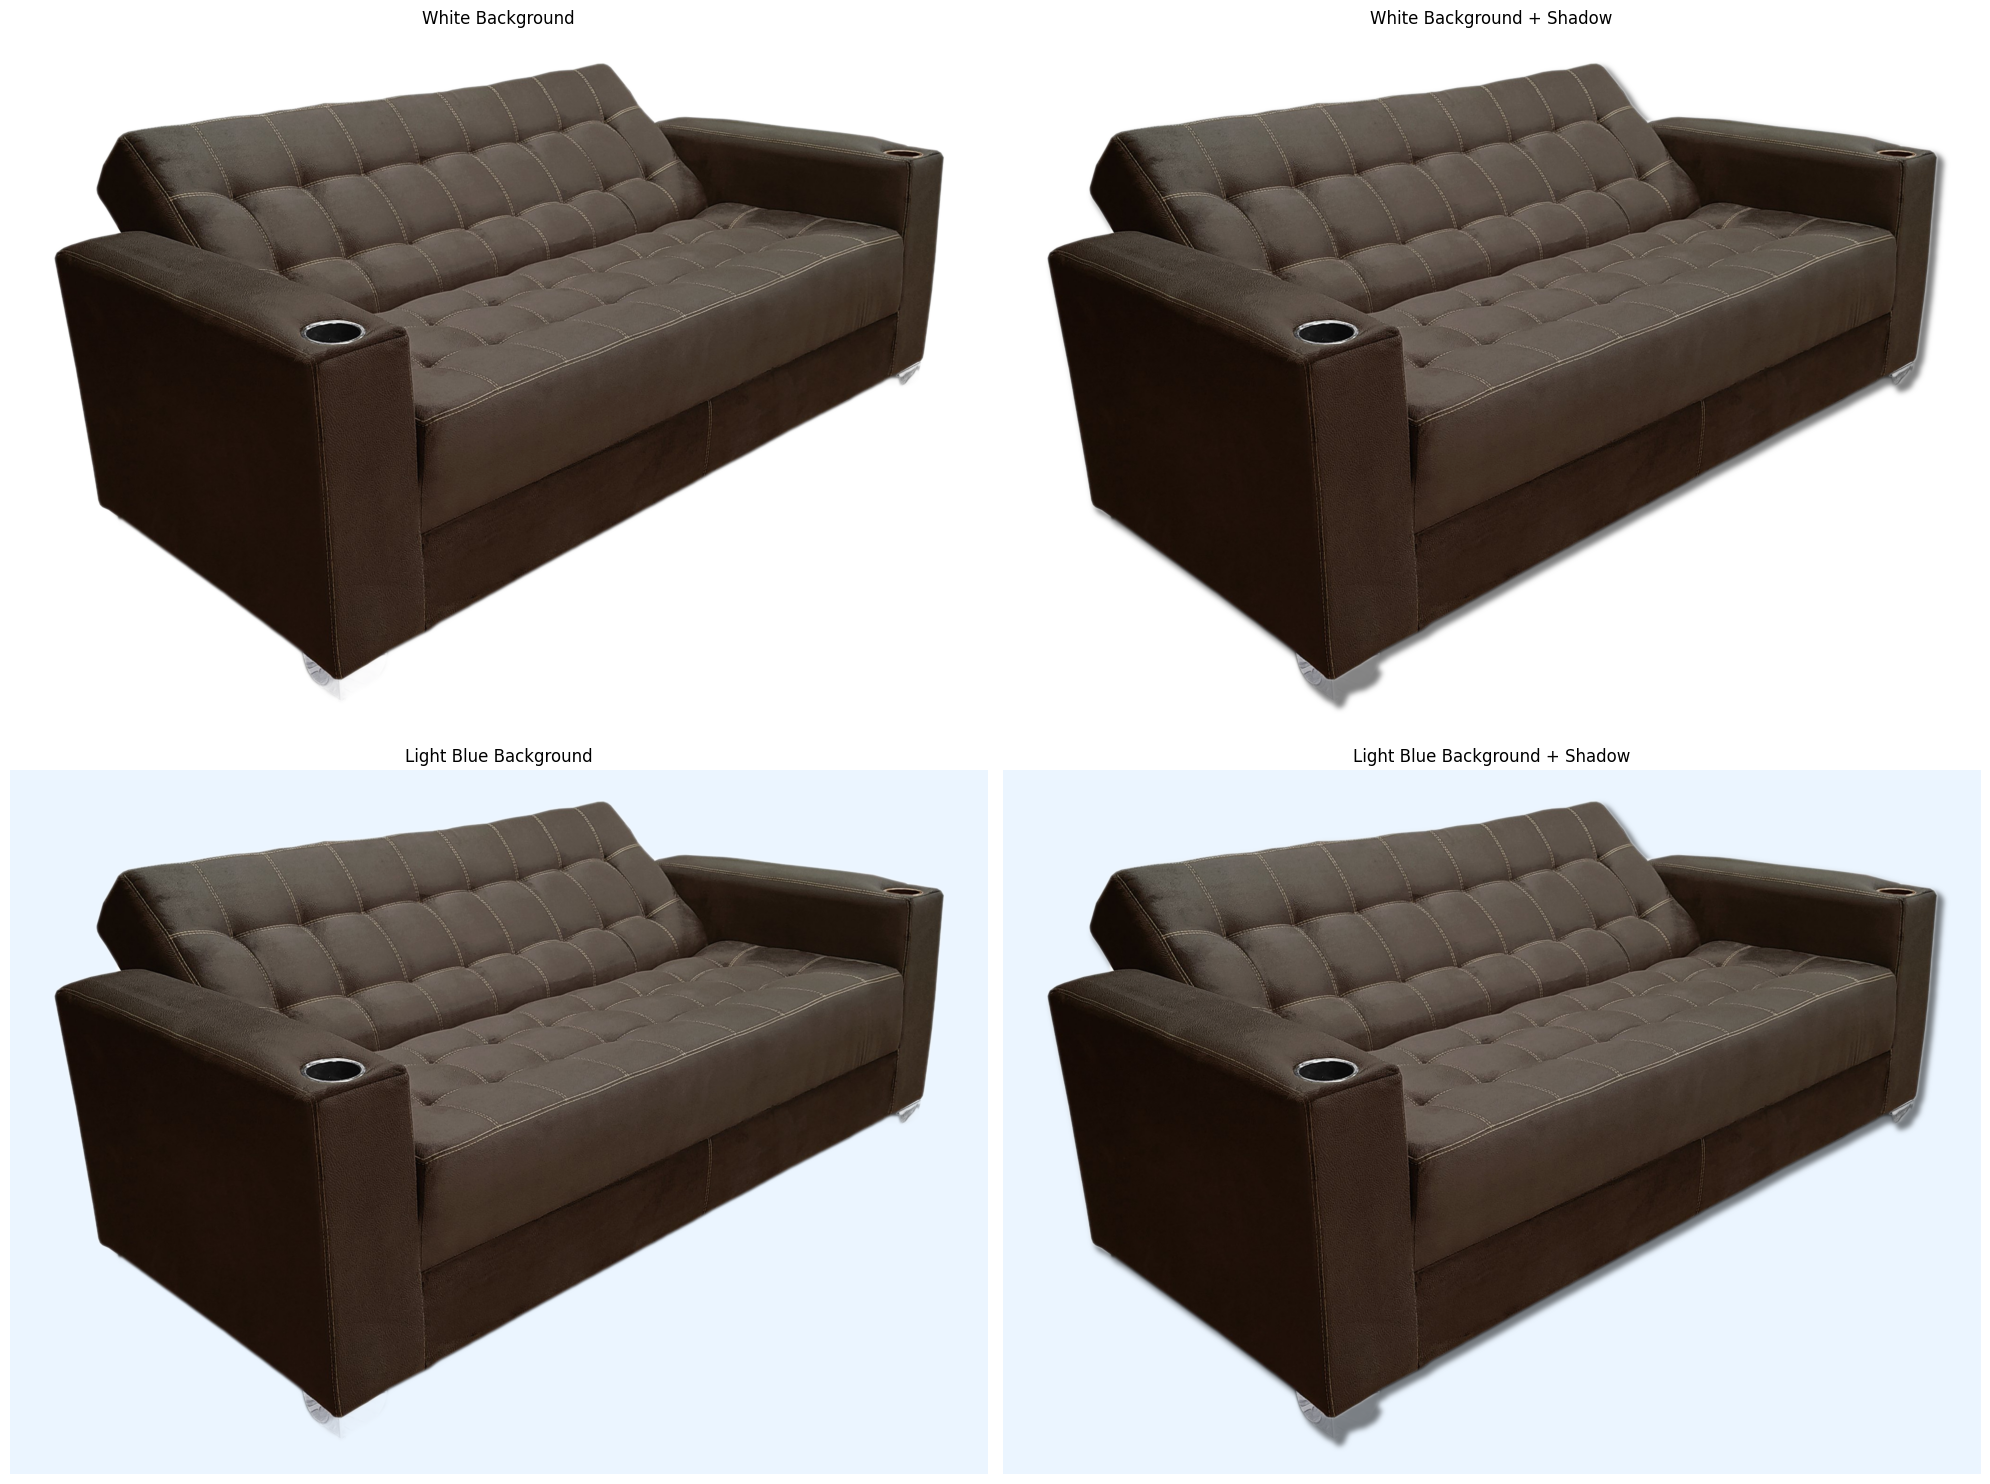

True

In [5]:
# Image dimensions for background generation
width, height = demo_image_pil.size

# Generate white background
white_bg = generate_solid_background(width, height, color=(255, 255, 255))
white_bg_np = np.array(white_bg)

# Generate colored background (light blue)
light_blue_bg = generate_solid_background(width, height, color=(235, 245, 255))
light_blue_bg_np = np.array(light_blue_bg)

# Combine foreground with backgrounds
white_result = combine_foreground_background(foreground_rgba_np, white_bg_np)
blue_result = combine_foreground_background(foreground_rgba_np, light_blue_bg_np)

# Add shadow (optional)
# Create shadow layer with offset
def add_shadow(foreground_rgba, background):
    # Extract alpha channel for shadow generation
    alpha = foreground_rgba[:, :, 3]
    h, w = alpha.shape
    
    # Create shadow mask with blur
    shadow_mask = (alpha > 10).astype(np.uint8) * 255
    blur_sigma = 5.0
    k_size = int(6 * blur_sigma + 1)
    if k_size % 2 == 0: k_size += 1
    shadow_mask = cv2.GaussianBlur(shadow_mask, (k_size, k_size), blur_sigma)
    
    # Create shadow layer with opacity
    shadow_layer = np.zeros((h, w, 4), dtype=np.uint8)
    shadow_color = (0, 0, 0)  # Black shadow
    shadow_layer[:, :, 0] = shadow_color[0]
    shadow_layer[:, :, 1] = shadow_color[1]
    shadow_layer[:, :, 2] = shadow_color[2]
    shadow_layer[:, :, 3] = (shadow_mask * 0.5).astype(np.uint8)  # 50% opacity
    
    # Shift shadow
    x_off, y_off = 10, 10  # Shadow offset
    M = np.float32([[1, 0, x_off], [0, 1, y_off]])
    shifted_shadow = cv2.warpAffine(shadow_layer, M, (w, h))
    
    # Convert to PIL for easier compositing
    shadow_pil = Image.fromarray(shifted_shadow)
    bg_pil = Image.fromarray(background).convert('RGBA')
    fg_pil = Image.fromarray(foreground_rgba)
    
    # Composite shadow onto background first, then foreground
    result = bg_pil.copy()
    result.paste(shadow_pil, (0, 0), shadow_pil)
    result.paste(fg_pil, (0, 0), fg_pil)
    
    return np.array(result.convert('RGB'))

# Add shadows to both backgrounds
white_result_with_shadow = add_shadow(foreground_rgba_np, white_bg_np)
blue_result_with_shadow = add_shadow(foreground_rgba_np, light_blue_bg_np)

# Show results
display_images([white_result, white_result_with_shadow, blue_result, blue_result_with_shadow],
               titles=["White Background", "White Background + Shadow", 
                       "Light Blue Background", "Light Blue Background + Shadow"],
               figsize=(20, 15), rows=2)

# Save results
save_image(Image.fromarray(white_result_with_shadow), RESULTS_DIR / "demo_white_bg.png")
save_image(Image.fromarray(blue_result_with_shadow), RESULTS_DIR / "demo_blue_bg.png")

## 6. Background Replacement - Gradient

Let's create gradient backgrounds and use them for composition.

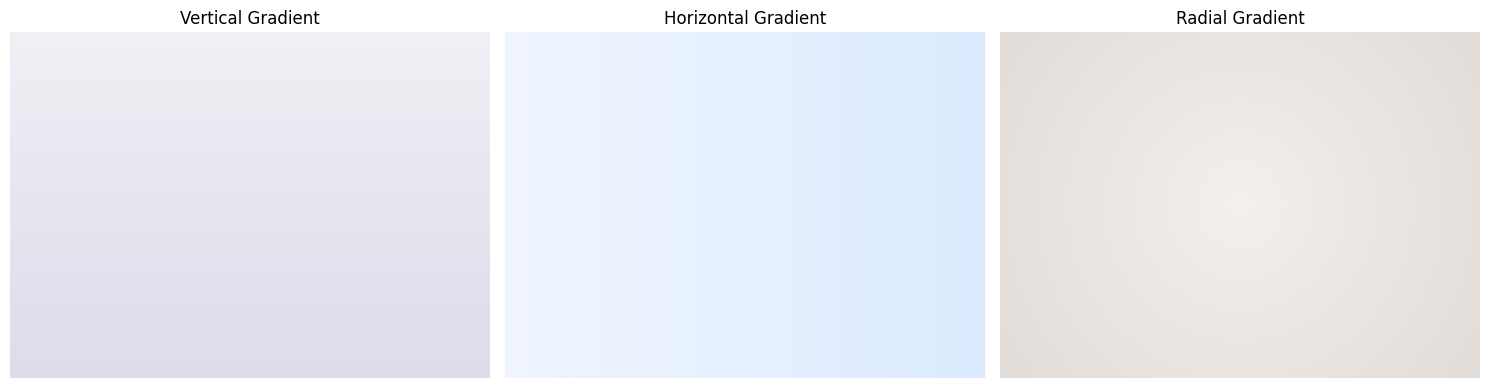

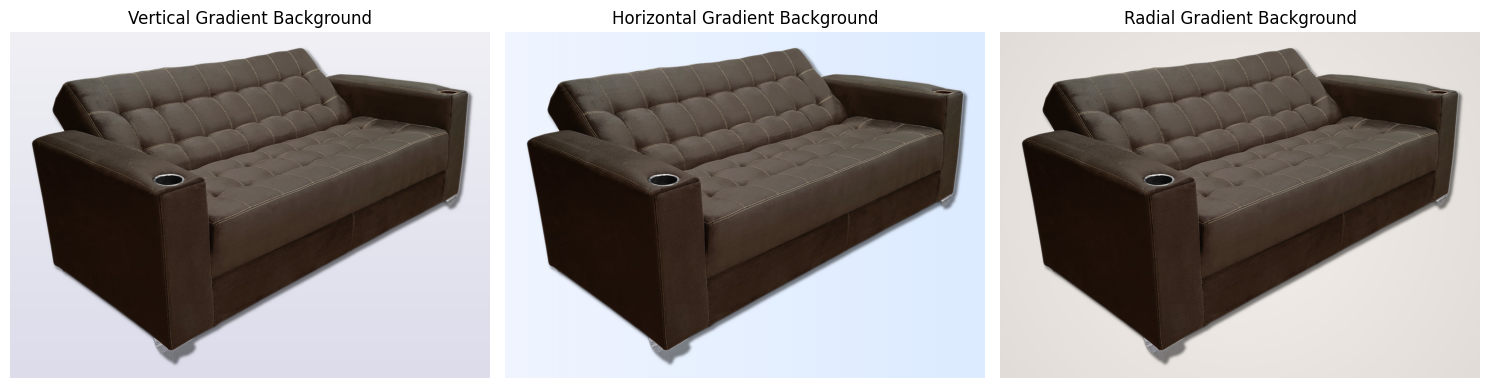

True

In [6]:
# Generate vertical gradient
vertical_gradient = generate_gradient_background(
    width, height, 
    colors=[(240, 240, 245), (220, 220, 235)], 
    direction='vertical'
)
vertical_gradient_np = np.array(vertical_gradient)

# Generate horizontal gradient
horizontal_gradient = generate_gradient_background(
    width, height, 
    colors=[(240, 245, 255), (220, 235, 255)], 
    direction='horizontal'
)
horizontal_gradient_np = np.array(horizontal_gradient)

# Generate radial gradient
radial_gradient = generate_gradient_background(
    width, height, 
    colors=[(245, 240, 235), (225, 220, 215)], 
    direction='radial'
)
radial_gradient_np = np.array(radial_gradient)

# Show the gradients
display_images([vertical_gradient, horizontal_gradient, radial_gradient],
               titles=["Vertical Gradient", "Horizontal Gradient", "Radial Gradient"])

# Combine foreground with gradients and add shadows
vertical_result = add_shadow(foreground_rgba_np, vertical_gradient_np)
horizontal_result = add_shadow(foreground_rgba_np, horizontal_gradient_np)
radial_result = add_shadow(foreground_rgba_np, radial_gradient_np)

# Show the results
display_images([vertical_result, horizontal_result, radial_result],
               titles=["Vertical Gradient Background", "Horizontal Gradient Background", "Radial Gradient Background"])

# Save results
save_image(Image.fromarray(vertical_result), RESULTS_DIR / "demo_vertical_gradient.png")
save_image(Image.fromarray(horizontal_result), RESULTS_DIR / "demo_horizontal_gradient.png")
save_image(Image.fromarray(radial_result), RESULTS_DIR / "demo_radial_gradient.png")

## 7. Background Replacement - Diffusion

Finally, let's use Stable Diffusion with ControlNet to generate custom backgrounds.

Using diffusion configuration from config.py:
Model ID: runwayml/stable-diffusion-v1-5
ControlNet Model ID: lllyasviel/sd-controlnet-seg
Guidance Scale: 7.5
ControlNet Scale: 0.63
Inference Steps: 25
Processing Resolution: (512, 512)

Using parameters: {'num_inference_steps': 25, 'guidance_scale': 7.5, 'controlnet_conditioning_scale': 0.63, 'target_processing_size': (512, 512), 'negative_prompt': 'low quality, bad quality, blurry, distorted, text, watermark'}
Generating background with prompt 1 (main.py prompt): 'Clean, neutral, photorealistic, professional studio background, soft lighting, light gray background, high quality product shot'
2025-04-27 23:47:22,767 - INFO - root - Resizing inputs from (1920x1383) to target processing size (512x512) for diffusion.
2025-04-27 23:47:22,828 - INFO - root - Generating background with prompt: 'Clean, neutral, photorealistic, professional studio background, soft lighting, light gray background, high quality product shot'


100%|██████████| 25/25 [02:49<00:00,  6.78s/it]


2025-04-27 23:50:14,899 - INFO - root - Resizing generated background from (512x512) back to original size (1920x1383).
2025-04-27 23:50:14,939 - INFO - root - Background generation finished.
Background generation completed in 172.21 seconds
Generating background with prompt 2 : 'Minimalist studio setting with soft lighting, clean white background'
2025-04-27 23:50:16,318 - INFO - root - Resizing inputs from (1920x1383) to target processing size (512x512) for diffusion.
2025-04-27 23:50:16,376 - INFO - root - Generating background with prompt: 'Minimalist studio setting with soft lighting, clean white background'


100%|██████████| 25/25 [02:49<00:00,  6.77s/it]


2025-04-27 23:53:08,097 - INFO - root - Resizing generated background from (512x512) back to original size (1920x1383).
2025-04-27 23:53:08,138 - INFO - root - Background generation finished.
Background generation completed in 171.85 seconds
Generating background with prompt 3 : 'Professional product photography studio with subtle shadow and clean background'
2025-04-27 23:53:09,146 - INFO - root - Resizing inputs from (1920x1383) to target processing size (512x512) for diffusion.
2025-04-27 23:53:09,205 - INFO - root - Generating background with prompt: 'Professional product photography studio with subtle shadow and clean background'


100%|██████████| 25/25 [02:49<00:00,  6.78s/it]


2025-04-27 23:56:01,102 - INFO - root - Resizing generated background from (512x512) back to original size (1920x1383).
2025-04-27 23:56:01,141 - INFO - root - Background generation finished.
Background generation completed in 172.03 seconds


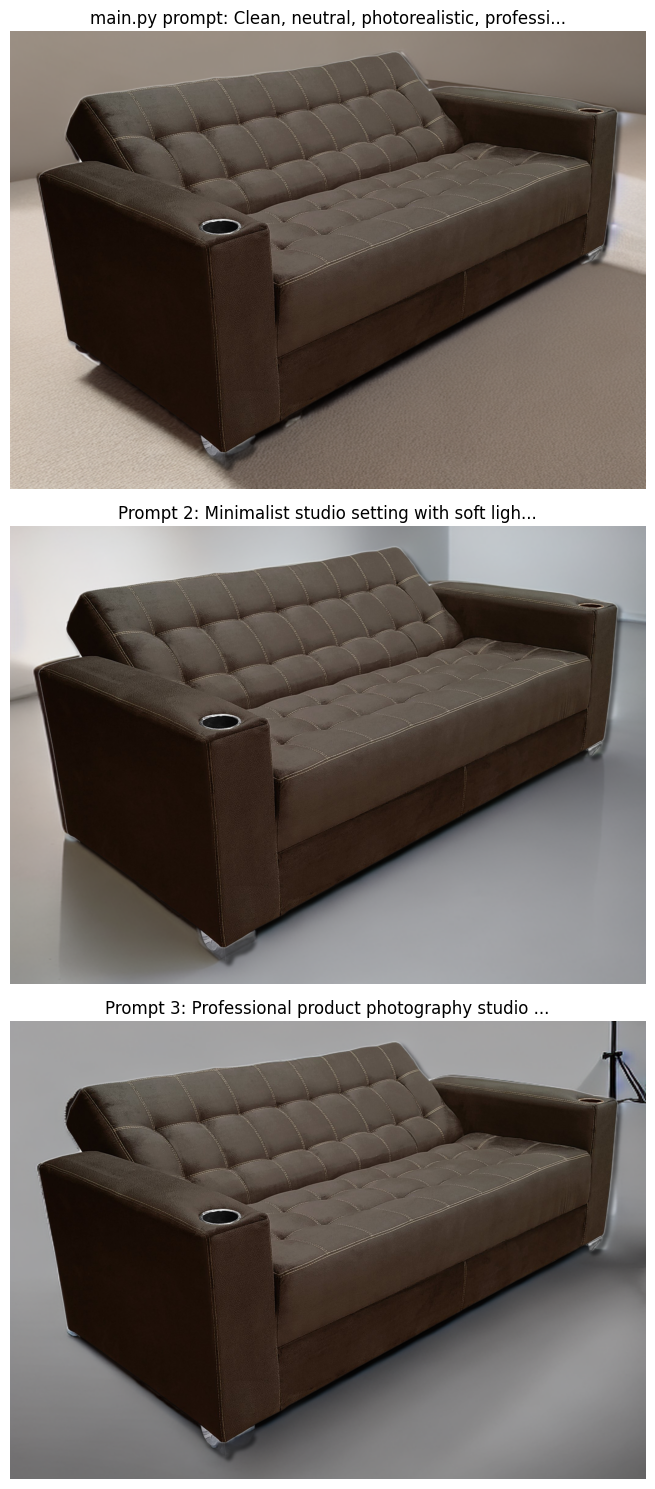

In [7]:
# Check if the diffusion generator is available
if pipeline.diffusion_generator is None:
    print("Diffusion generator is not available. Skipping this section.")
else:
    # Get diffusion configuration from DEFAULT_CONFIG
    print("Using diffusion configuration from config.py:")
    print(f"Model ID: {DEFAULT_CONFIG['diffusion_model_id']}")
    print(f"ControlNet Model ID: {DEFAULT_CONFIG['diffusion_controlnet_model_id']}")
    print(f"Guidance Scale: {DEFAULT_CONFIG['diffusion_guidance_scale']}")
    print(f"ControlNet Scale: {DEFAULT_CONFIG['diffusion_controlnet_scale']}")
    print(f"Inference Steps: {DEFAULT_CONFIG['diffusion_num_inference_steps']}")
    print(f"Processing Resolution: {DEFAULT_CONFIG['diffusion_processing_resolution']}")
    
    # Define prompt from main.py
    main_prompt = "Clean, neutral, photorealistic, professional studio background, soft lighting, light gray background, high quality product shot"
    
    # Additional prompts for comparison
    prompts = [
        main_prompt,  # From main.py
        "Minimalist studio setting with soft lighting, clean white background",
        "Professional product photography studio with subtle shadow and clean background"
    ]
    
    # Set generation parameters from config.py
    diffusion_params = {
        "num_inference_steps": DEFAULT_CONFIG["diffusion_num_inference_steps"],
        "guidance_scale": DEFAULT_CONFIG["diffusion_guidance_scale"],
        "controlnet_conditioning_scale": DEFAULT_CONFIG["diffusion_controlnet_scale"],
        "target_processing_size": DEFAULT_CONFIG["diffusion_processing_resolution"],
        "negative_prompt": "low quality, bad quality, blurry, distorted, text, watermark"
    }
    
    print(f"\nUsing parameters: {diffusion_params}")
    
    # Generate backgrounds with different prompts
    diffusion_results = []
    diffusion_titles = []
    
    for i, prompt in enumerate(prompts):
        prompt_desc = "(main.py prompt)" if i == 0 else ""
        print(f"Generating background with prompt {i+1} {prompt_desc}: '{prompt}'")
        start_time = time.time()
        
        # Convert mask to PIL
        final_mask_pil = Image.fromarray(feathered_mask).convert('L')
        
        # Generate background
        try:
            generated_bg = pipeline.diffusion_generator.generate(
                image_input=demo_image_pil,
                foreground_mask=final_mask_pil,
                prompt=prompt,
                **diffusion_params
            )
            generation_time = time.time() - start_time
            print(f"Background generation completed in {generation_time:.2f} seconds")
            
            # Save the generated background
            save_image(generated_bg, RESULTS_DIR / f"demo_diffusion_bg_{i+1}.png")
            
            # Combine foreground with the generated background
            generated_bg_np = np.array(generated_bg)
            combined_result = add_shadow(foreground_rgba_np, generated_bg_np)
            
            # Save the combined result
            save_image(Image.fromarray(combined_result), RESULTS_DIR / f"demo_diffusion_result_{i+1}.png")
            
            # Store for display
            diffusion_results.append(combined_result)
            label = "main.py prompt" if i == 0 else f"Prompt {i+1}"
            diffusion_titles.append(f"{label}: {prompt[:40]}...")
            
        except Exception as e:
            print(f"Error generating background: {e}")
    
    # Display the results
    if diffusion_results:
        display_images(diffusion_results, diffusion_titles, figsize=(20, 15), rows=len(diffusion_results))

## 8. Conclusion and Performance Analysis

Let's compare the different approaches and analyze the performance considerations.

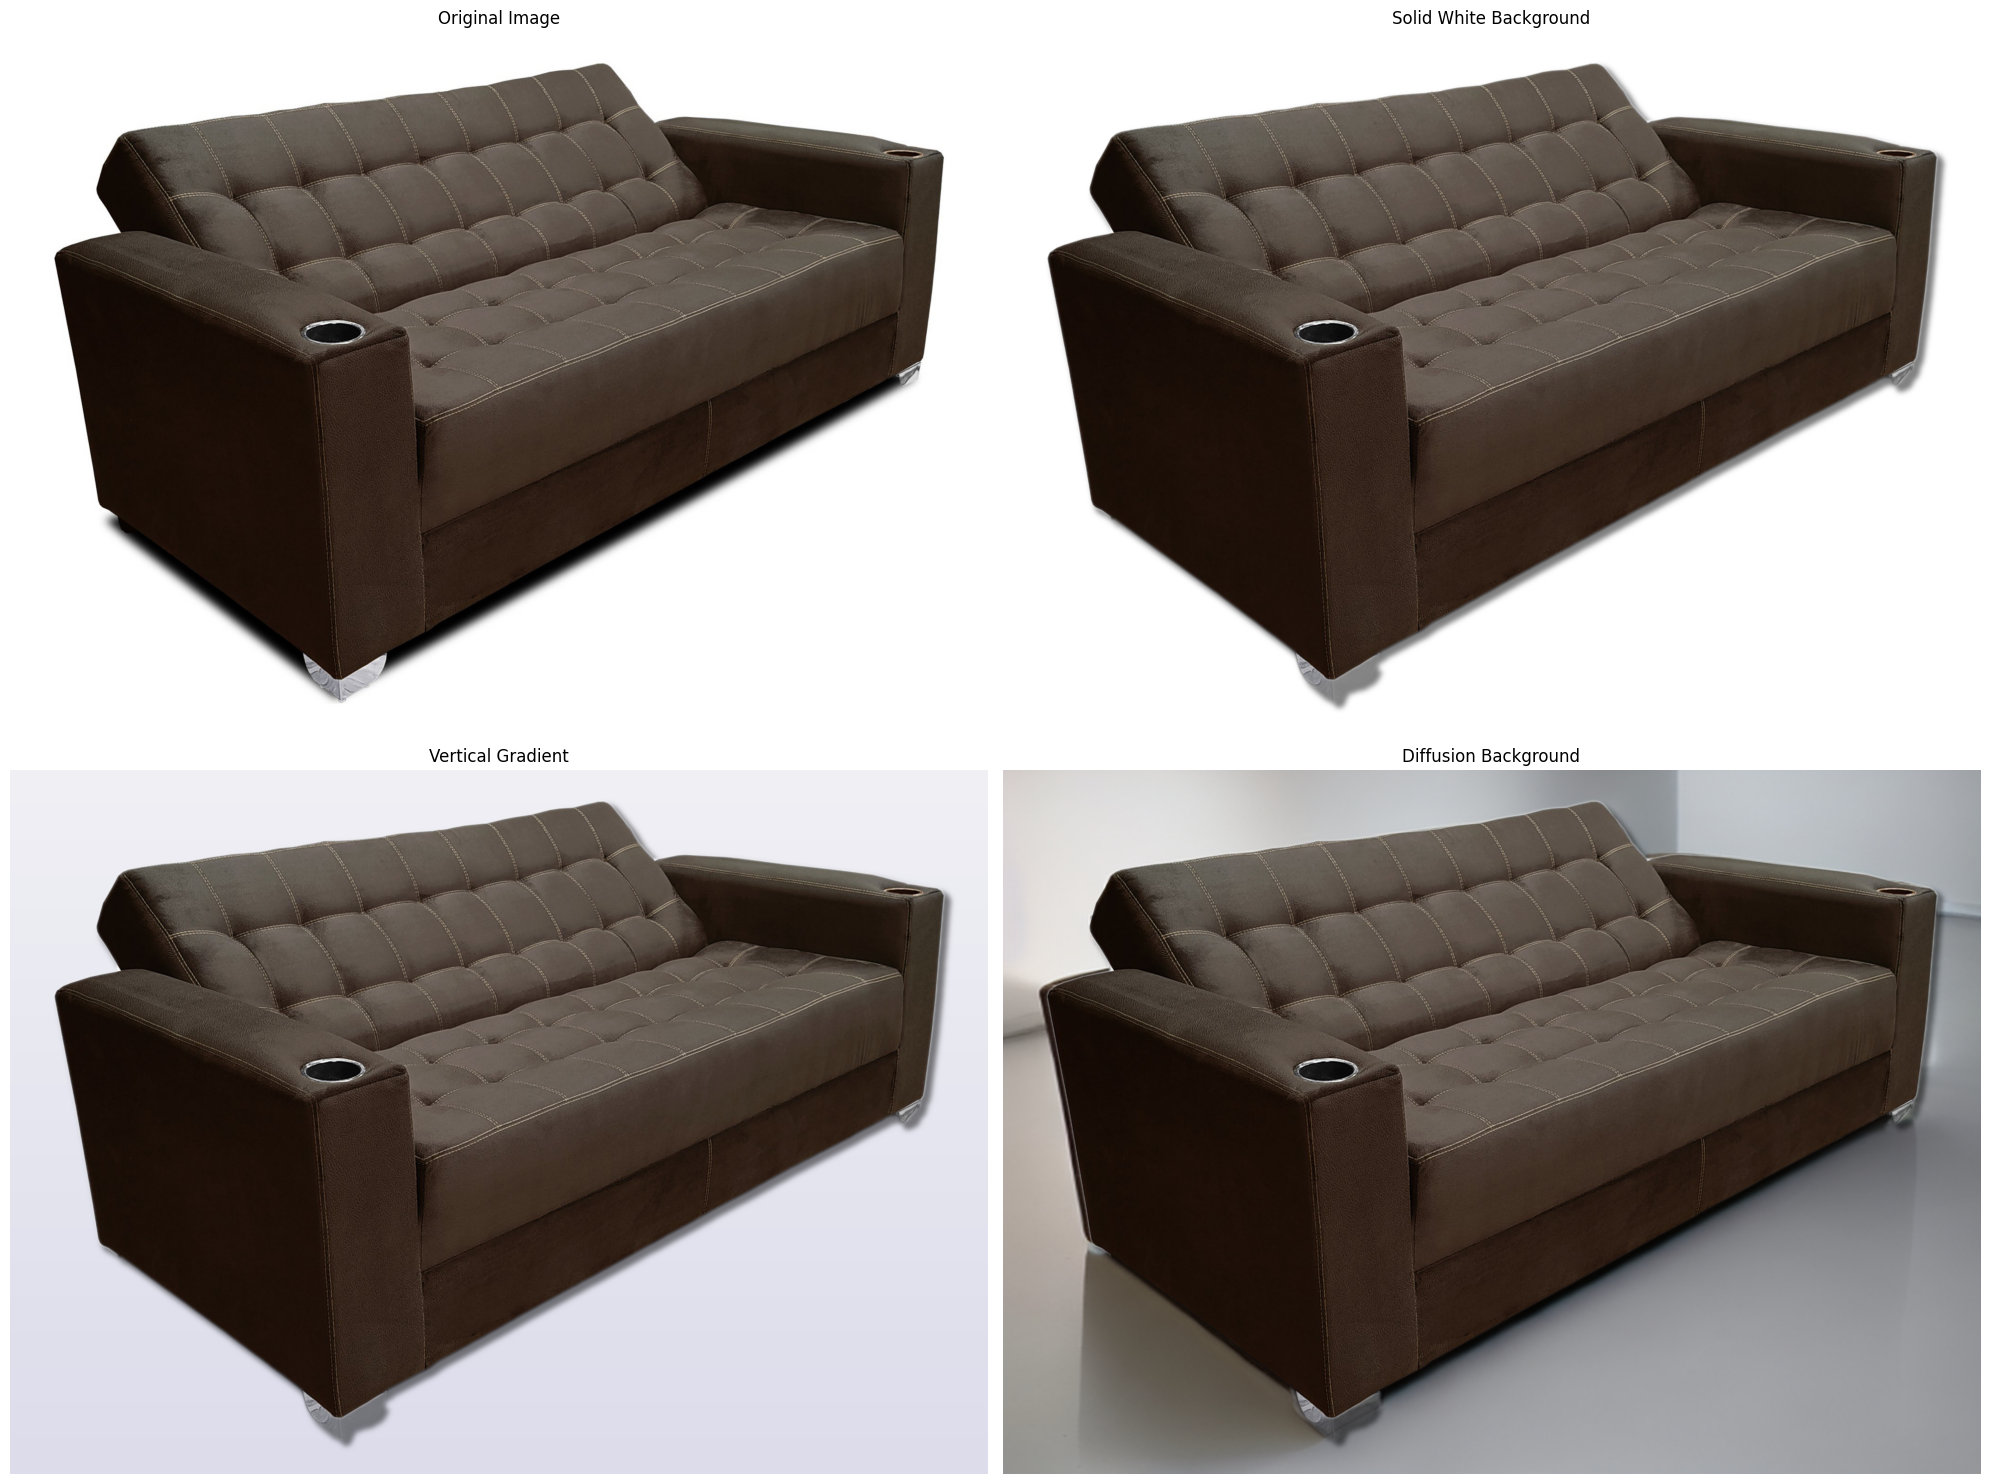

Performance Analysis:

1. Computational Requirements:
   - Solid Color Backgrounds: Very low computation, instant generation
   - Gradient Backgrounds: Low computation, nearly instant generation
   - Diffusion Backgrounds: High computation, requires GPU for reasonable speed

2. Quality Considerations:
   - Solid Color Backgrounds: Clean, professional but simple
   - Gradient Backgrounds: More visual interest while maintaining simplicity
   - Diffusion Backgrounds: High customization but may introduce artifacts

3. Use Case Recommendations:
   - For e-commerce catalog bulk processing: Use solid colors or gradients
   - For featured products: Consider diffusion for unique, custom backgrounds
   - For maximum quality control: Solid colors or gradients ensure consistency

4. Pipeline Efficiency:
   - Segmentation is a bottleneck for all methods
   - Mask refinement significantly improves quality with minimal cost
   - Diffusion generation is the most expensive step when enabled


In [9]:
# Load all the generated results for comparison
final_results = []
final_titles = []

# Add original image
final_results.append(demo_image_np)
final_titles.append("Original Image")

# Add solid background results
final_results.append(white_result_with_shadow)
final_titles.append("Solid White Background")

# Add gradient result
final_results.append(vertical_result)
final_titles.append("Vertical Gradient")

# Add diffusion result if available
if 'diffusion_results' in locals() and diffusion_results:
    final_results.append(diffusion_results[1])
    final_titles.append("Diffusion Background")

# Display final comparison
display_images(final_results, final_titles, figsize=(20, 15), rows=2)

# Performance discussion
print("Performance Analysis:")
print("\n1. Computational Requirements:")
print("   - Solid Color Backgrounds: Very low computation, instant generation")
print("   - Gradient Backgrounds: Low computation, nearly instant generation")
print("   - Diffusion Backgrounds: High computation, requires GPU for reasonable speed")

print("\n2. Quality Considerations:")
print("   - Solid Color Backgrounds: Clean, professional but simple")
print("   - Gradient Backgrounds: More visual interest while maintaining simplicity")
print("   - Diffusion Backgrounds: High customization but may introduce artifacts")

print("\n3. Use Case Recommendations:")
print("   - For e-commerce catalog bulk processing: Use solid colors or gradients")
print("   - For featured products: Consider diffusion for unique, custom backgrounds")
print("   - For maximum quality control: Solid colors or gradients ensure consistency")

print("\n4. Pipeline Efficiency:")
print("   - Segmentation is a bottleneck for all methods")
print("   - Mask refinement significantly improves quality with minimal cost")
print("   - Diffusion generation is the most expensive step when enabled")